# Cognition & Computation - Lab 2

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv

from DBN import DBN

In [4]:
%%capture
mnist_train = tv.datasets.MNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

mnist_test = tv.datasets.MNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [5]:
mnist_train.data = (mnist_train.data.type(torch.FloatTensor)/255)
mnist_test.data = (mnist_test.data.type(torch.FloatTensor)/255)

In [6]:
dbn_mnist = DBN(visible_units=28*28,
                hidden_units=[500],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.0002,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=False)

In [7]:
num_epochs = 40
batch_size = 125

dbn_mnist.train_static(
    mnist_train.data,
    mnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |mean_cost |std_cost  |mean_grad |std_grad  |
|01    |4.0554    |2.3252    |1234.0868 |3375.0303   |
|02    |2.0551    |0.2200    |1268.9420 |96.1497   |
|03    |1.7485    |0.1387    |1363.1017 |87.9864   |
|04    |1.6031    |0.1142    |1369.0383 |85.7508   |
|05    |1.5299    |0.1050    |1377.1744 |92.4993   |
|06    |1.9932    |0.3176    |1249.8380 |187.8126   |
|07    |1.7336    |0.1439    |1165.7277 |87.2877   |
|08    |1.6672    |0.1347    |1149.4706 |90.4328   |
|09    |1.6174    |0.1313    |1153.7695 |84.4913   |
|10    |1.5781    |0.1276    |1145.9779 |89.4619   |
|11    |1.5546    |0.1289    |1148.8971 |91.9041   |
|12    |1.5217    |0.1155    |1150.9894 |84.0518   |
|13    |1.5110    |0.1287    |1161.4692 |97.2287   |
|14    |1.4957    |0.1196    |1165.6724 |88.2524   |
|15    |1.4746    |0.1117    |1166.1080 |82.9219   |
|16    |1.4609    |0.1146    |1175.0497 |85.3658   |
|17    |1.4473    |0.1221    |1178.4518 |99.5451   |
|

## Linear readouts

In [8]:
def _move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [9]:
_move_parameters_to_cpu(dbn_mnist)

Let's first compute the hidden representations:

In [10]:
def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_mnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [11]:
hidden_repr_layer_1 = _get_kth_layer_repr(mnist_train.data, 0)

In [12]:
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 10)

  def forward(self, x):
    return self.linear(x)

### First hidden layer representations

Let's train the readout layer:

In [13]:
def _train(network, input, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    loss = loss_fn(predictions, mnist_train.targets)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [14]:
rbm_layer_size = dbn_mnist.rbm_layers[0].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_1, epochs=1500)

epoch 0/1500, loss = 2.348271
epoch 100/1500, loss = 0.853837
epoch 200/1500, loss = 0.577023
epoch 300/1500, loss = 0.465381
epoch 400/1500, loss = 0.403555
epoch 500/1500, loss = 0.363445
epoch 600/1500, loss = 0.334866
epoch 700/1500, loss = 0.313205
epoch 800/1500, loss = 0.296058
epoch 900/1500, loss = 0.282038
epoch 1000/1500, loss = 0.270288
epoch 1100/1500, loss = 0.260246
epoch 1200/1500, loss = 0.251527
epoch 1300/1500, loss = 0.243856
epoch 1400/1500, loss = 0.237034


Let's test it on the hold-out dataset:

In [15]:
hidden_repr_layer_1_test = _get_kth_layer_repr(mnist_test.data, 0)

In [16]:
predictions_first_hidden = perceptron_first_hidden(hidden_repr_layer_1_test)

In [17]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [18]:
_compute_accuracy(predictions_first_hidden, mnist_test.targets)

0.9495000243186951

## Comparison with a feedforward model

Let's now train a simple feedforward neural network with the same structure as the RBM, i.e. with one hidden layer with `500` units.

We want to compare a network that is trained end-to-end to solve a classification task with a simple classifier that solves the same task using representations of input data learned in an *unsupervised* way.

In [19]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [20]:
ffnn = Feedforward(500)

We choose the number of epochs to match the training time of the RBM and the readout layer combined.

In [21]:
_train(ffnn, mnist_train.data.reshape((60000, 784)), epochs=120)

epoch 0/120, loss = 2.295774
epoch 10/120, loss = 2.181697
epoch 20/120, loss = 2.056005
epoch 30/120, loss = 1.908311
epoch 40/120, loss = 1.740372
epoch 50/120, loss = 1.563734
epoch 60/120, loss = 1.393866
epoch 70/120, loss = 1.242721
epoch 80/120, loss = 1.115220
epoch 90/120, loss = 1.010638
epoch 100/120, loss = 0.925611
epoch 110/120, loss = 0.856274


In [22]:
predictions_ffnn = ffnn(mnist_test.data.reshape((10000, 784)))

In [23]:
_compute_accuracy(predictions_ffnn, mnist_test.targets)

0.8407999873161316

## Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the RBM are robust to noise.

In [24]:
def _inject_noise(mnist_data, noise_level):
  random_gaussian_tensor = torch.randn(mnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(mnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return mnist_data - mask_tensor * mnist_data + mask_tensor * random_gaussian_tensor

Let's see what a noisy image looks like:

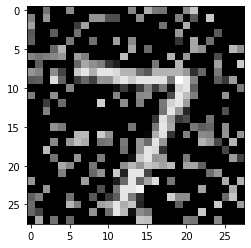

In [25]:
noise_level = 0.3
mnist_test_with_noise = _inject_noise(mnist_test.data, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28), cmap="gray")

We will now compute the hidden representations for the noisy images using the RBM. Then, we will use the models that we trained on the representations without noise to classify the noisy ones.

In [26]:
def _get_accuracy_values_at_noise_level(noise_level):
  mnist_test_with_noise = _inject_noise(mnist_test.data, noise_level)
  hidden_repr_layer_1_noisy = _get_kth_layer_repr(mnist_test_with_noise, 0)  # here we compute the representations
  predictions_first_hidden_noisy = perceptron_first_hidden(hidden_repr_layer_1_noisy)  # here we use the readout layer
  predictions_ffnn_noisy = ffnn(mnist_test_with_noise.reshape((10000, 784)))
  accuracy_first_hidden = _compute_accuracy(predictions_first_hidden_noisy, mnist_test.targets)
  accuracy_ffnn = _compute_accuracy(predictions_ffnn_noisy, mnist_test.targets)
  return accuracy_first_hidden, accuracy_ffnn

In [27]:
_get_accuracy_values_at_noise_level(0.2)

(0.7955999970436096, 0.8234000205993652)

Let's now get an overview of the robustness of the representations to different levels of noise:

In [28]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    accuracy_first_hidden, accuracy_ffnn = _get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(accuracy_first_hidden)
    accuracy_values_ffnn.append(accuracy_ffnn)

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "FFNN"])

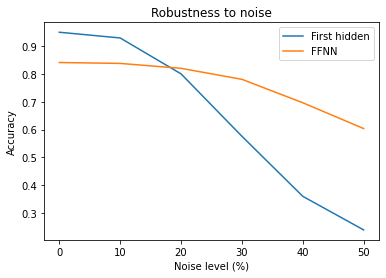

In [29]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plot_noise_robustness_curves(noise_levels)

## Contacts

- 📧 flavio.petruzzellis@phd.unipd.it
- 💬 [Moodle forum](https://elearning.unipd.it/math/mod/forum/view.php?id=36439)